In [ ]:
# 使用 matplotlib 的 inline 模式，让图表直接在 notebook 中显示
%matplotlib inline

# 导入操作系统相关的模块，用于文件路径操作
import os

# 导入 pandas 库，用于读取和处理 CSV 文件
import pandas as pd

# 导入 PyTorch 深度学习框架
import torch

# 导入 torchvision 库，提供计算机视觉相关的工具和数据集
import torchvision

# 导入 d2l (Dive into Deep Learning) 工具库的 PyTorch 版本
from d2l import torch as d2l

In [ ]:
# 在 d2l 库的数据中心(DATA_HUB)中注册香蕉检测数据集
# DATA_HUB 是一个字典，存储了各种数据集的下载链接和校验码
d2l.DATA_HUB['banana-detection'] = (
    # 第一个元素：数据集的下载 URL
    # DATA_URL 是 d2l 库中定义的基础数据 URL
    d2l.DATA_URL + 'banana-detection.zip',
    # 第二个元素：数据集的 SHA-1 校验码，用于验证下载文件的完整性
    # 确保下载的文件没有损坏或被篡改
    '5de26c8fce5ccdea9f91267273464dc968d20d72'
)

In [ ]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签
    
    参数说明：
    is_train: 布尔值，True 表示读取训练集，False 表示读取验证集
    
    返回值：
    images: 图像列表，每个元素是一个图像张量
    targets: 标签张量，形状为 (样本数, 1, 5)，包含类别和边界框坐标
    """
    # 下载并解压香蕉检测数据集，返回数据集所在的目录路径
    # 一般为../data/banana-detection
    data_dir = d2l.download_extract('banana-detection')
    
    # 构造 CSV 标签文件的完整路径
    # os.path.join() 用于拼接路径，适配不同操作系统
    # 根据 is_train 参数选择训练集或验证集的文件夹
    csv_fname = os.path.join(
        data_dir, 
        'bananas_train' if is_train else 'bananas_val',  # 选择训练或验证文件夹
        'label.csv'  # 标签文件名
    )
    
    # 使用 pandas 读取 CSV 文件
    # CSV 文件包含图像文件名和对应的标签信息（类别、边界框坐标）
    csv_data = pd.read_csv(csv_fname)
    
    # 将 'img_name' 列设置为索引，方便后续通过图像名称访问数据
    csv_data = csv_data.set_index('img_name')
    
    # 初始化两个空列表，用于存储图像和标签
    images, targets = [], []
    
    # 遍历 CSV 数据的每一行
    # iterrows() 返回索引（img_name）和该行数据（target）
    for img_name, target in csv_data.iterrows():
        # 读取并添加图像到 images 列表
        images.append(
            # torchvision.io.read_image() 读取图像文件并转换为张量
            torchvision.io.read_image(
                # 构造图像文件的完整路径
                os.path.join(
                    data_dir,  # 数据集根目录
                    'bananas_train' if is_train else 'bananas_val',  # 训练或验证文件夹
                    'images',  # 图像文件夹
                    f'{img_name}'  # 图像文件名（使用 f-string 格式化）
                )
            )
        )
        # 将当前行的标签数据转换为列表并添加到 targets
        # target 包含类别和边界框的坐标信息
        targets.append(list(target))
    
    # 将标签列表转换为 PyTorch 张量
    # unsqueeze(1) 在第二个维度增加一维，从 (n, 5) 变为 (n, 1, 5)
    # 除以 256 是为了将像素坐标归一化到 [0, 1] 范围
    # （假设图像尺寸为 256x256）
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [ ]:
class BananasDataset(torch.utils.data.Dataset):
    """香蕉检测数据集类
    
    继承自 torch.utils.data.Dataset，这是 PyTorch 中自定义数据集的标准方式
    需要实现三个方法：__init__、__getitem__、__len__
    """
    
    def __init__(self, is_train=True):
        """初始化数据集
        
        参数说明：
        is_train: 布尔值，True 表示加载训练集，False 表示加载验证集
        """
        # 调用 read_data_bananas 函数读取图像和标签
        # self.features 存储所有图像数据
        # self.labels 存储所有标签数据
        self.features, self.labels = read_data_bananas(is_train)
        
        # 打印读取的样本数量，方便用户了解数据集大小
        # str(len(self.features)) 将样本数量转换为字符串
        # 使用三元运算符根据 is_train 选择不同的提示文本
        print('read ' + str(len(self.features)) + 
              (' training examples' if is_train else ' validation examples'))

    def __getitem__(self, idx):
        """获取指定索引的样本
        
        参数说明：
        idx: 整数，样本的索引位置
        
        返回值：
        元组 (图像, 标签)
        """
        # 返回第 idx 个样本
        # self.features[idx].float() 将图像张量转换为浮点型（便于后续计算）
        # self.labels[idx] 返回对应的标签
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        """返回数据集的样本总数
        
        返回值：
        整数，数据集中的样本数量
        """
        # 返回特征列表的长度，即样本总数
        return len(self.features)

In [ ]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集，返回训练和验证数据迭代器
    
    参数说明：
    batch_size: 整数，每个批次包含的样本数量
    
    返回值：
    train_iter: 训练集数据迭代器
    val_iter: 验证集数据迭代器
    """
    # 创建训练集的数据加载器（DataLoader）
    train_iter = torch.utils.data.DataLoader(
        # 第一个参数：BananasDataset 训练集对象
        BananasDataset(is_train=True),
        # 第二个参数：批次大小，决定每次迭代返回多少个样本
        batch_size,
        # shuffle=True：每个 epoch 开始时打乱数据顺序
        # 这有助于提高模型的泛化能力，避免学习到数据的顺序信息
        shuffle=True
    )
    
    # 创建验证集的数据加载器
    val_iter = torch.utils.data.DataLoader(
        # 第一个参数：BananasDataset 验证集对象
        BananasDataset(is_train=False),
        # 第二个参数：批次大小
        batch_size
        # 注意：验证集不需要打乱数据，所以没有 shuffle 参数
    )
    
    # 返回训练集和验证集的迭代器
    return train_iter, val_iter

In [ ]:
# 设置批次大小为 32（每次读取 32 个样本）
batch_size = 32

# 设置图像边长为 256 像素（用于后续坐标还原）
edge_size = 256

# 加载香蕉检测数据集，获取训练集和验证集的迭代器
train_iter, val_iter = load_data_bananas(batch_size)

# 从训练集迭代器中获取第一个批次的数据
# iter(train_iter) 将数据加载器转换为迭代器
# next() 获取迭代器的下一个元素（即第一个批次）
batch = next(iter(train_iter))

# 打印批次数据的形状
# batch[0] 是图像数据，形状为 (batch_size, channels, height, width)
# batch[1] 是标签数据，形状为 (batch_size, 1, 5)
# 5 个值分别是：类别、左上角x、左上角y、右下角x、右下角y（归一化坐标）
print(batch[0].shape, batch[1].shape)

read 1000 training examples
read 100 validation examples
torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 5])


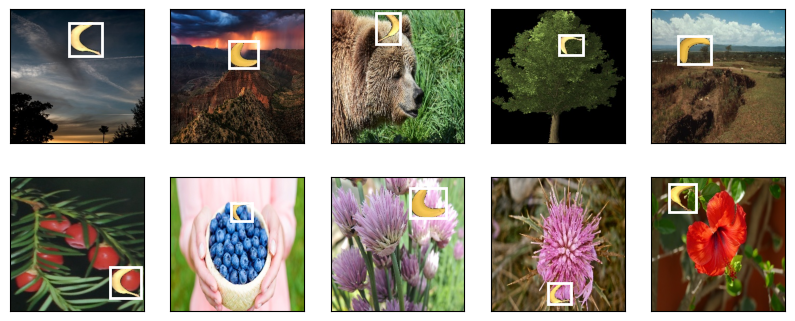

In [ ]:
# 从批次中取出前 10 张图像进行可视化
# batch[0][0:10] 选择前 10 个样本的图像
# permute(0,2,3,1) 调整张量维度顺序：
#   从 (batch, channels, height, width) 
#   变为 (batch, height, width, channels)
#   这是因为 matplotlib 显示图像需要 (height, width, channels) 格式
# 除以 255 将像素值从 [0, 255] 归一化到 [0, 1] 范围
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255

# 使用 d2l 库的 show_images 函数显示图像网格
# 参数说明：
#   imgs: 要显示的图像列表
#   2: 显示 2 行
#   5: 显示 5 列（总共 2x5=10 张图像）
#   scale=2: 图像显示的缩放比例
# 返回值 axes 是一个包含所有子图坐标轴对象的列表
axes = d2l.show_images(imgs, 2, 5, scale=2)

# 遍历每个子图和对应的标签，在图像上绘制边界框
# zip(axes, batch[1][0:10]) 将坐标轴和标签配对
for ax, label in zip(axes, batch[1][0:10]):
    # 在当前子图上显示边界框
    d2l.show_bboxes(
        ax,  # 当前子图的坐标轴对象
        # label[0][1:5] 提取边界框坐标（跳过第一个元素，即类别）
        # [1:5] 表示取索引 1 到 4 的元素：左上角x、左上角y、右下角x、右下角y
        # * edge_size 将归一化坐标 [0, 1] 还原为实际像素坐标 [0, 256]
        # 外层的 [] 是因为 show_bboxes 需要一个边界框列表
        [label[0][1:5] * edge_size],
        # colors=['w'] 设置边界框颜色为白色（white）
        colors=['w']
    )